<a href="https://colab.research.google.com/github/sydoky/Transfer-Learning-Scaled-Up/blob/main/Transfer_Learning_Scaled_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-18 17:58:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-18 17:58:03 (107 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [3]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-07-18 17:58:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 172.217.194.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  80.3MB/s    in 19s     

2022-07-18 17:58:26 (81.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_toast'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/guacamole'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pad_thai'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/breakfast_burrito'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pancakes'.
There are 0 directories and 250 images in '101_food

In [5]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [6]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [7]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  
], name="data_augmentation")

In [8]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [9]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 [==============================] - 92s 314ms/step - loss: 3.4700 - accuracy: 0.2491 - val_loss: 2.5389 - val_accuracy: 0.4510
Epoch 2/5
237/237 [==============================] - 60s 249ms/step - loss: 2.3403 - accuracy: 0.4611 - val_loss: 2.1457 - val_accuracy: 0.4910
Epoch 3/5
237/237 [==============================] - 55s 228ms/step - loss: 1.9790 - accuracy: 0.5290 - val_loss: 2.0014 - val_accuracy: 0.5066
Epoch 4/5
237/237 [==============================] - 51s 214ms/step - loss: 1.7541 - accuracy: 0.5773 - val_loss: 1.8952 - val_accuracy: 0.5162
Epoch 5/5
237/237 [==============================] - 47s 197ms/step - loss: 1.6095 - accuracy: 0.6026 - val_loss: 1.8154 - val_accuracy: 0.5238


In [10]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 58s 74ms/step - loss: 1.7151 - accuracy: 0.5525


[1.715123176574707, 0.5524752736091614]

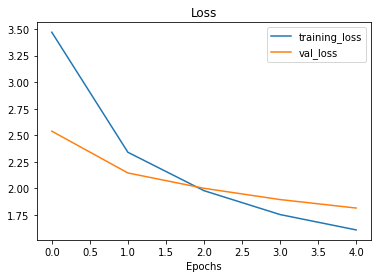

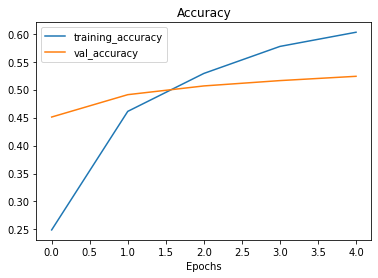

In [11]:
plot_loss_curves(history_all_classes_10_percent)

In [12]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [13]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [14]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [15]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [16]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 [==============================] - 52s 189ms/step - loss: 1.3578 - accuracy: 0.6478 - val_loss: 1.7965 - val_accuracy: 0.5275
Epoch 6/10
237/237 [==============================] - 45s 187ms/step - loss: 1.2279 - accuracy: 0.6784 - val_loss: 1.8337 - val_accuracy: 0.5233
Epoch 7/10
237/237 [==============================] - 40s 169ms/step - loss: 1.1539 - accuracy: 0.6969 - val_loss: 1.8126 - val_accuracy: 0.5222
Epoch 8/10
237/237 [==============================] - 41s 173ms/step - loss: 1.0802 - accuracy: 0.7084 - val_loss: 1.7986 - val_accuracy: 0.5262
Epoch 9/10
237/237 [==============================] - 37s 155ms/step - loss: 1.0301 - accuracy: 0.7259 - val_loss: 1.8208 - val_accuracy: 0.5265
Epoch 10/10
237/237 [==============================] - 38s 157ms/step - loss: 0.9723 - accuracy: 0.7407 - val_loss: 1.7856 - val_accuracy: 0.5331


In [17]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 58s 73ms/step - loss: 1.6155 - accuracy: 0.5745


[1.615468144416809, 0.5745346546173096]

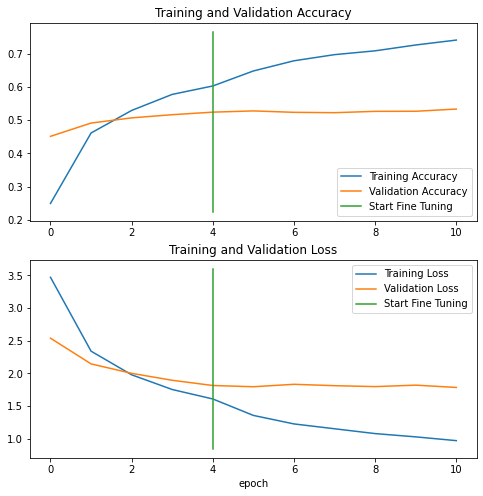

In [18]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [19]:
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 57s 72ms/step - loss: 1.6155 - accuracy: 0.5745


(1.615468144416809, 0.5745346546173096)

In [20]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

790/790 [==============================] - 61s 76ms/step


In [21]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0,  8, 29, 78, 29,  0,  9,  0])

In [22]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [23]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5745346534653465

In [24]:
from locale import normalize
from sklearn.utils.fixes import threadpool_limits
from helper_functions import make_confusion_matrix 

import itertools

import matplotlib.pyplot as plt

import numpy as np 

from sklearn.metrics import confusion_matrix


def make_confusion_matrix(y_true,y_pred,classes=None,figsize=(10,10),text_size=15,norm=False,savefig=False):


  #Create confusion matrix

  cm=confusion_matrix(y_true,y_pred)

  cm_norm=cm.astype("float")/cm.sum(axis=1)[:,np.newaxis] #normalize it

  n_classes=cm.shape[0]


  #plot the figure and make it pretty

  fig,ax=plt.subplots(figsize=figsize)

  cax=ax.matshow(cm,cmap=plt.cm.Blues)

  fig.colorbar(cax)
  

  if classes:
    labels=classes 
  else:
    labels=np.arange(cm.shape[0])
  

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()


  plt.xticks(rotation=70,fontsize=text_size)
  plt.yticks(fontsize=text_size)



  threshold=(cm.max()+cm.min())/2

  for i ,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    if norm:
      plt.text(j,i,f"{cm[i,j]} ({cm_norm[i,j]*100:.1f}%)",
               horizontalalignment="center",
               color="white" if cm[i,j] > threshold else "black",
               size=text_size)
    else:
      plt.text(j,i,f"{cm[i,j]}",
                 horizontalalignment="center",
                 color="white" if cm[i,j] > threshold else "black",
                 size=text_size)
  

  if savefig:
    fig.savefig("Misha_conf_mat.png")
               
               
               









In [25]:
pred_classes

array([  0,   0,   0, ..., 100, 100, 100])

In [26]:
class_names=test_data.class_names

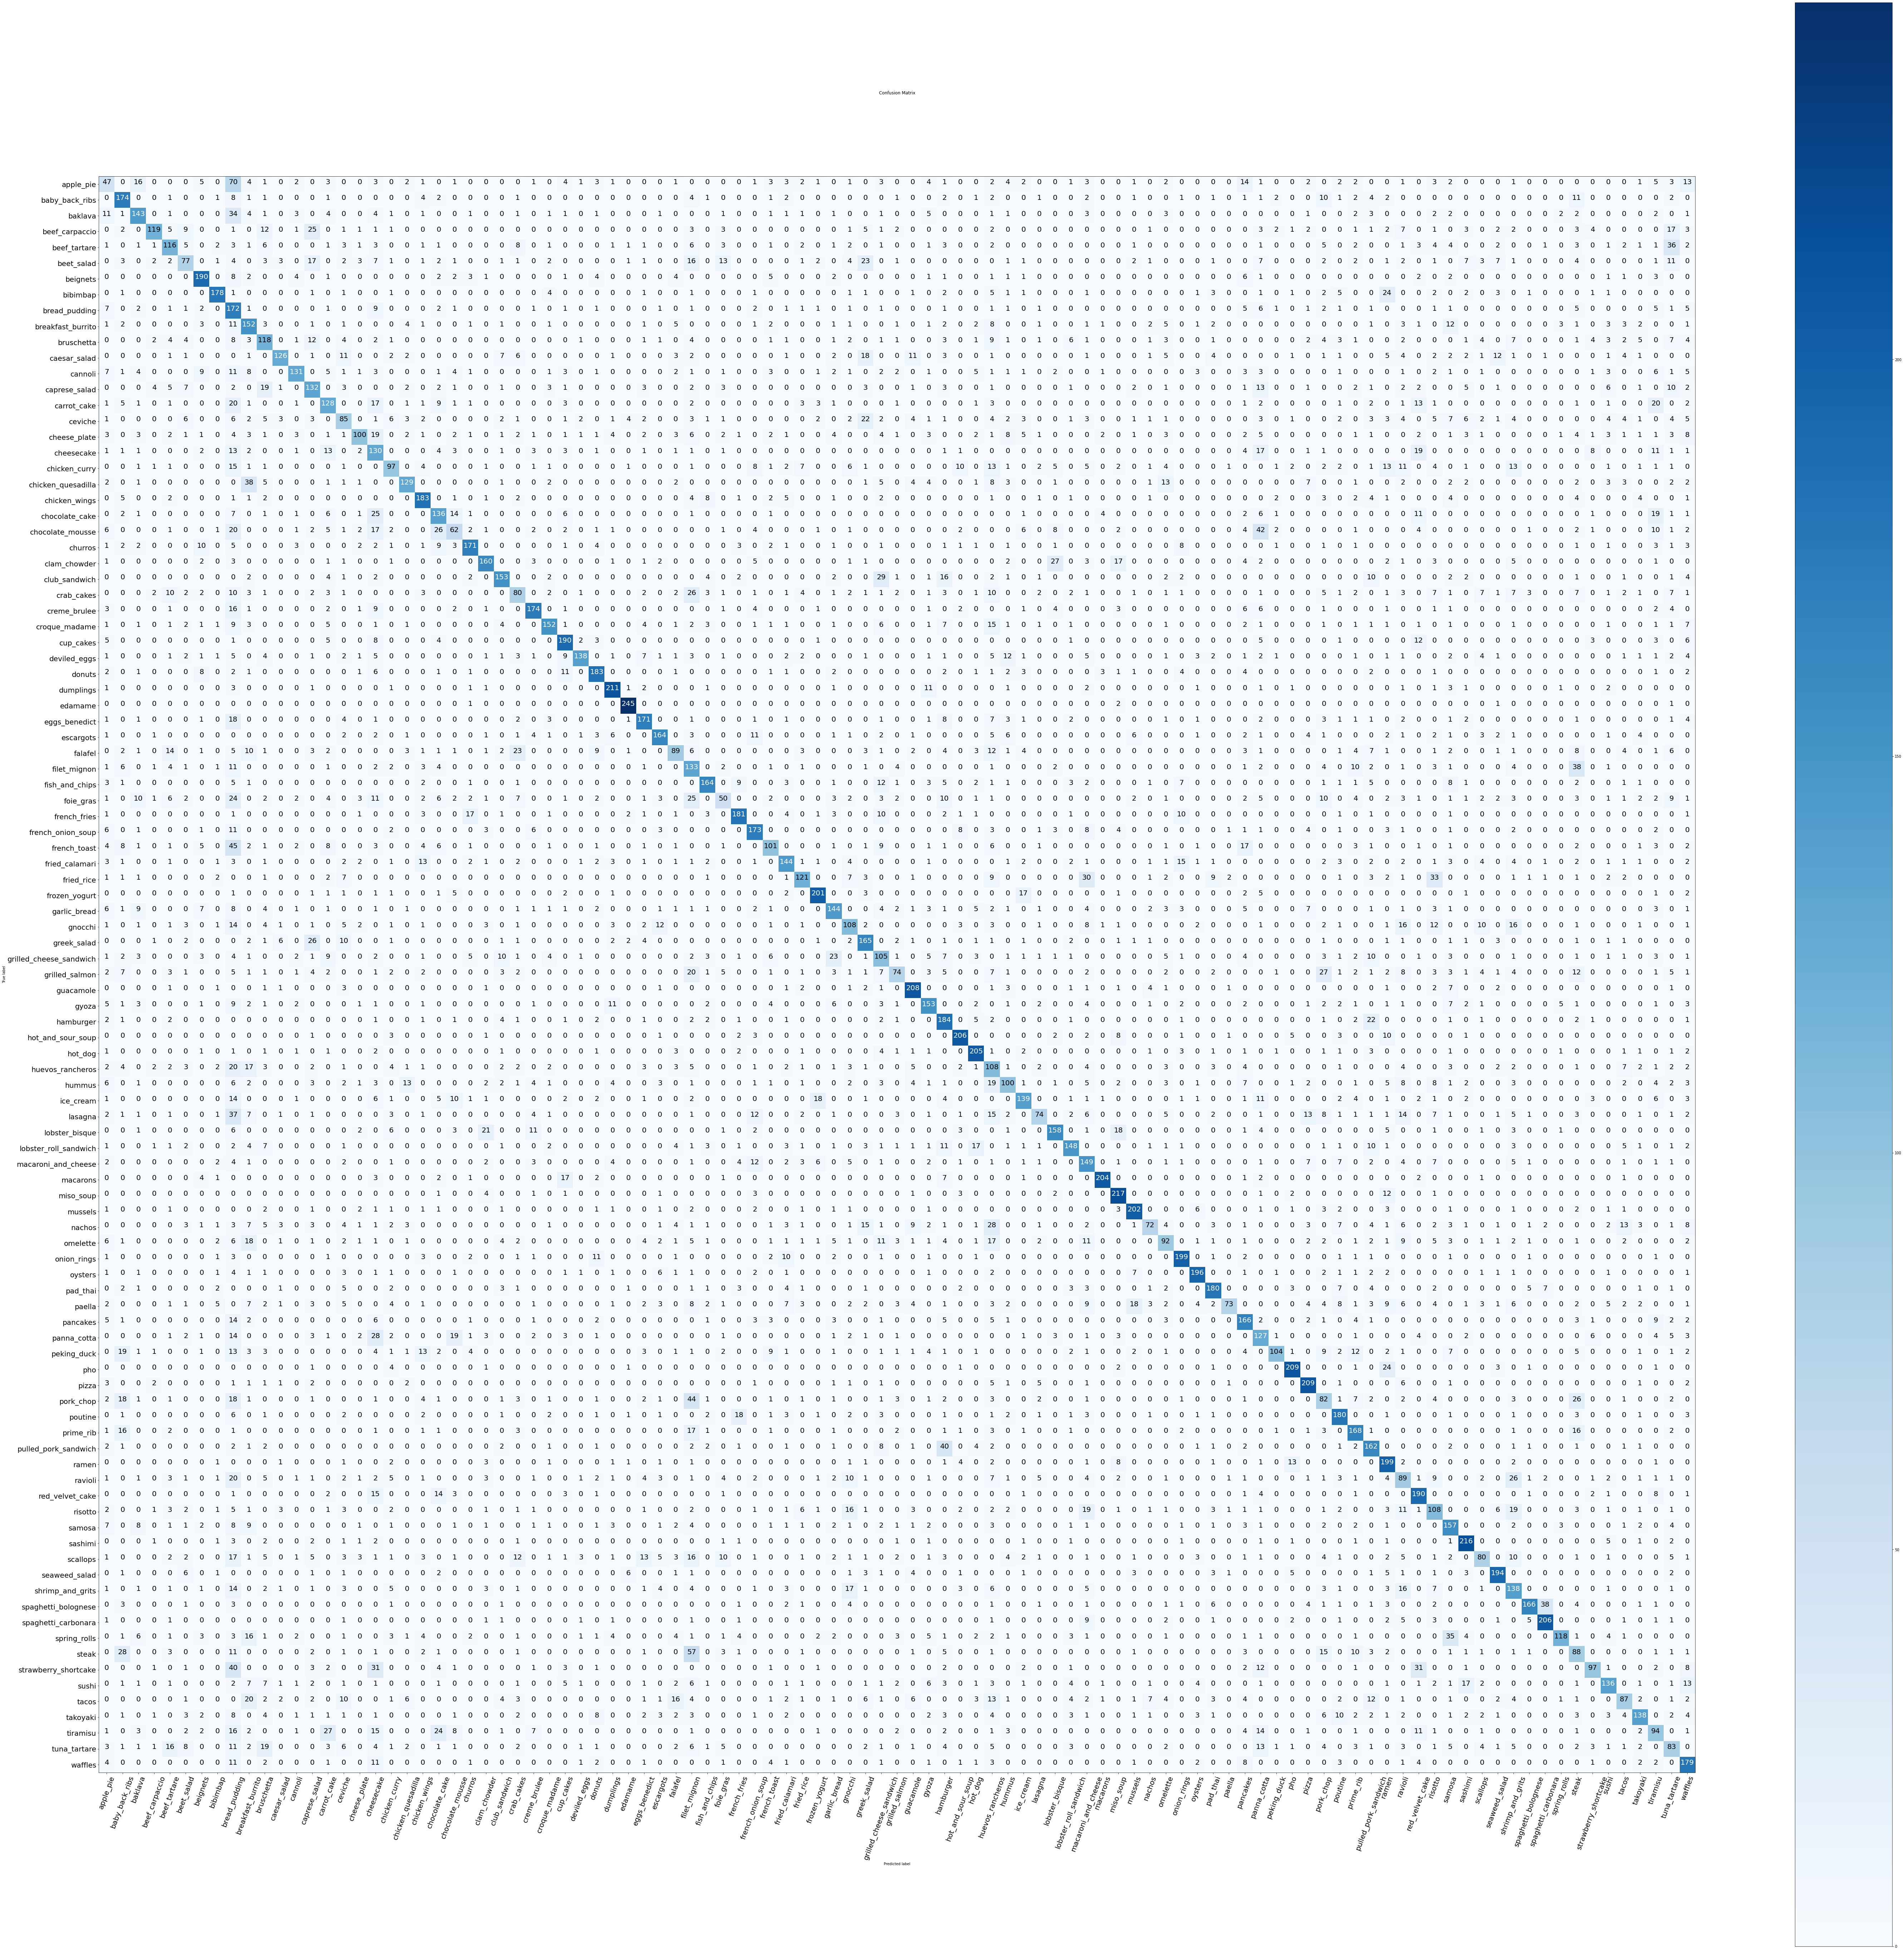

In [27]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      norm=False,
                      savefig=True
                      )

# **The next step is ,we are going to check classification report**

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_labels,pred_classes))

              precision    recall  f1-score   support

           0       0.23      0.19      0.21       250
           1       0.53      0.70      0.60       250
           2       0.60      0.57      0.59       250
           3       0.82      0.48      0.60       250
           4       0.50      0.46      0.48       250
           5       0.47      0.31      0.37       250
           6       0.70      0.76      0.73       250
           7       0.83      0.71      0.77       250
           8       0.17      0.69      0.28       250
           9       0.40      0.61      0.48       250
          10       0.42      0.47      0.45       250
          11       0.80      0.50      0.62       250
          12       0.77      0.52      0.62       250
          13       0.48      0.53      0.50       250
          14       0.49      0.51      0.50       250
          15       0.39      0.34      0.36       250
          16       0.71      0.40      0.51       250
          17       0.29    

In [29]:
#Make a dictionary of the classfication Report

classification_report_dict=classification_report(y_labels,pred_classes,output_dict=True)

classification_report_dict

{'0': {'f1-score': 0.2079646017699115,
  'precision': 0.23267326732673269,
  'recall': 0.188,
  'support': 250},
 '1': {'f1-score': 0.6,
  'precision': 0.5272727272727272,
  'recall': 0.696,
  'support': 250},
 '10': {'f1-score': 0.44612476370510395,
  'precision': 0.4229390681003584,
  'recall': 0.472,
  'support': 250},
 '100': {'f1-score': 0.593698175787728,
  'precision': 0.5070821529745042,
  'recall': 0.716,
  'support': 250},
 '11': {'f1-score': 0.6191646191646192,
  'precision': 0.802547770700637,
  'recall': 0.504,
  'support': 250},
 '12': {'f1-score': 0.6223277909738718,
  'precision': 0.7660818713450293,
  'recall': 0.524,
  'support': 250},
 '13': {'f1-score': 0.5019011406844107,
  'precision': 0.4782608695652174,
  'recall': 0.528,
  'support': 250},
 '14': {'f1-score': 0.5019607843137256,
  'precision': 0.49230769230769234,
  'recall': 0.512,
  'support': 250},
 '15': {'f1-score': 0.36402569593147754,
  'precision': 0.391705069124424,
  'recall': 0.34,
  'support': 250},

In [30]:
class_f1_scores={}

for k,v in classification_report_dict.items():
  if k=="accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]]=v["f1-score"]
class_f1_scores

{'apple_pie': 0.2079646017699115,
 'baby_back_ribs': 0.6,
 'baklava': 0.5872689938398357,
 'beef_carpaccio': 0.601010101010101,
 'beef_tartare': 0.48232848232848236,
 'beet_salad': 0.3710843373493976,
 'beignets': 0.7265774378585086,
 'bibimbap': 0.7672413793103448,
 'bread_pudding': 0.2785425101214575,
 'breakfast_burrito': 0.4794952681388012,
 'bruschetta': 0.44612476370510395,
 'caesar_salad': 0.6191646191646192,
 'cannoli': 0.6223277909738718,
 'caprese_salad': 0.5019011406844107,
 'carrot_cake': 0.5019607843137256,
 'ceviche': 0.36402569593147754,
 'cheese_plate': 0.5115089514066496,
 'cheesecake': 0.37572254335260113,
 'chicken_curry': 0.44907407407407407,
 'chicken_quesadilla': 0.5986078886310906,
 'chicken_wings': 0.6971428571428572,
 'chocolate_cake': 0.5141776937618148,
 'chocolate_mousse': 0.3054187192118227,
 'churros': 0.7154811715481171,
 'clam_chowder': 0.6736842105263158,
 'club_sandwich': 0.652452025586354,
 'crab_cakes': 0.3669724770642202,
 'creme_brulee': 0.71311475

In [31]:
import pandas as pd
f1_scores=pd.DataFrame({"Class Name": list(class_f1_scores.keys()),
                        "f1-score":list(class_f1_scores.values())})

In [32]:
f1_scores

,Class Name,f1-score
0,apple_pie,0.207965
1,baby_back_ribs,0.600000
2,baklava,0.587269
3,beef_carpaccio,0.601010
4,beef_tartare,0.482328
...,...,...
96,tacos,0.417266
97,takoyaki,0.616071
98,tiramisu,0.374502
99,tuna_tartare,0.321083


# **Visualizing Predictions on Test Images**

In [33]:
def load_and_prep_image(filename,img_shape=224,scale=True):


  #Read in the image
  img=tf.io.read_file(filename)

  #Decode it into a tensor
  img=tf.io.decode_image(img)

  #Resize the img
  img=tf.image.resize(img,[img_shape,img_shape])
  if scale:
    return img/255.
  else:
    return img

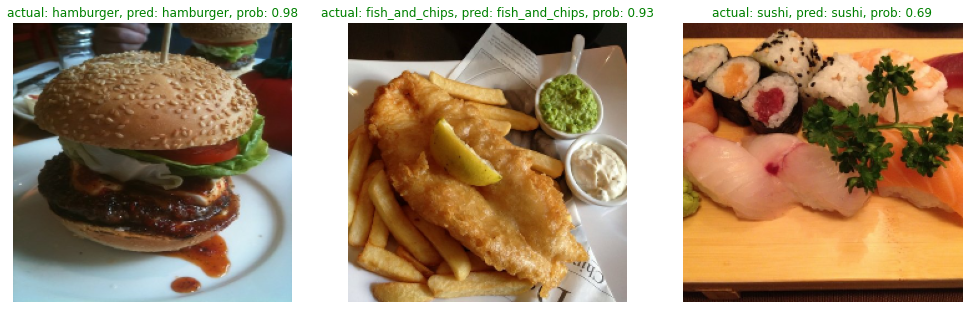

In [34]:
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  #choose a random image from a random class
  class_name=random.choice(class_names)
  filename=random.choice(os.listdir(test_dir + "/" +class_name))
  filepath=test_dir+class_name+"/"+filename

  #Load the image and make predictions

  img=load_and_prep_image(filepath,scale=False) 
  pred_prob=model.predict(tf.expand_dims(img,axis=0))
  pred_class=class_names[pred_prob.argmax()] #Find the predicted class


  #plot the images
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)

  if class_name==pred_class:
    title_color="g"
  else:
    title_color="r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}",c=title_color)
  plt.axis(False)



# **Finding the most wrong predictions**

In [35]:
filepaths=[]
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [36]:
#Create a dataframe out of current prediction data for analysis

import pandas as pd
pred_df=pd.DataFrame({"img_path":filepaths,
                      "y_true":y_labels,
                      "y_pred":pred_classes,
                      "pred_conf":pred_probs.max(axis=1),
                      "y_true_classname":[class_names[i] for i in y_labels],
                      "y_pred_classname":[class_names[i] for i in pred_classes]})

pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.598180,apple_pie,apple_pie
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.917547,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.278605,apple_pie,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,8,0.237637,apple_pie,bread_pudding
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,29,0.385243,apple_pie,cup_cakes


In [37]:
pred_df["pred_correct"]=pred_df["y_true"]==pred_df["y_pred"]

In [38]:
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.598180,apple_pie,apple_pie,True
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.917547,apple_pie,apple_pie,True
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.278605,apple_pie,apple_pie,True
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,8,0.237637,apple_pie,bread_pudding,False
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,29,0.385243,apple_pie,cup_cakes,False
...,...,...,...,...,...,...,...
25245,b'101_food_classes_10_percent/test/waffles/942...,100,100,0.972338,waffles,waffles,True
25246,b'101_food_classes_10_percent/test/waffles/954...,100,100,0.950493,waffles,waffles,True
25247,b'101_food_classes_10_percent/test/waffles/961...,100,100,0.513101,waffles,waffles,True
25248,b'101_food_classes_10_percent/test/waffles/970...,100,100,0.474114,waffles,waffles,True


In [40]:
#get the 100 wrong examples

top_100_wrong=pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf",ascending=False)[:100]

top_100_wrong

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
23797,b'101_food_classes_10_percent/test/sushi/16593...,95,86,0.998058,sushi,sashimi,False
23631,b'101_food_classes_10_percent/test/strawberry_...,94,83,0.997243,strawberry_shortcake,red_velvet_cake,False
11642,b'101_food_classes_10_percent/test/garlic_brea...,46,10,0.997056,garlic_bread,bruschetta,False
10847,b'101_food_classes_10_percent/test/fried_calam...,43,68,0.996468,fried_calamari,onion_rings,False
18001,b'101_food_classes_10_percent/test/pancakes/10...,72,67,0.995101,pancakes,omelette,False
...,...,...,...,...,...,...,...
10741,b'101_food_classes_10_percent/test/french_toas...,42,1,0.957305,french_toast,baby_back_ribs,False
10289,b'101_food_classes_10_percent/test/french_onio...,41,62,0.956398,french_onion_soup,macaroni_and_cheese,False
1309,b'101_food_classes_10_percent/test/beet_salad/...,5,7,0.956308,beet_salad,bibimbap,False
21782,b'101_food_classes_10_percent/test/scallops/14...,87,69,0.955918,scallops,oysters,False


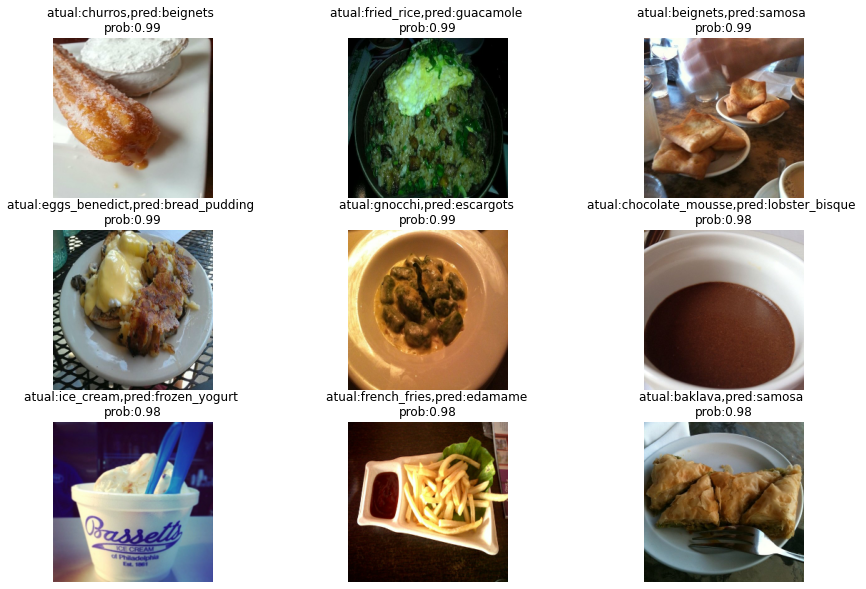

In [42]:
#Visualize some of the wrong examples
images_to_view=9
start_index=10

plt.figure(figsize=(15,10))

for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img=load_and_prep_image(row[1],scale=True)
  _,_,_,_,pred_prob,y_true,y_pred,_=row
  plt.imshow(img)
  plt.title(f"atual:{y_true},pred:{y_pred} \nprob:{pred_prob:.2f}")
  plt.axis(False)

# **Test Out the Model on custom images**

In [43]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip 

--2022-07-18 18:40:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 172.217.194.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  8.82MB/s    in 1.4s    

2022-07-18 18:40:24 (8.82 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [44]:
unzip_data("custom_food_images.zip")

In [45]:
#Get the filepaths
custom_food_image=["custom_food_images/"+img_path for img_path in os.listdir("custom_food_images")]
custom_food_image

['custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg']

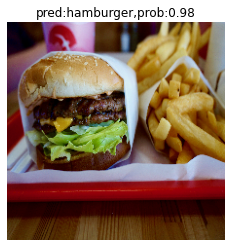

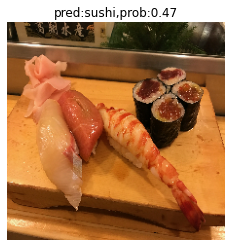

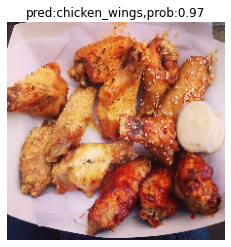

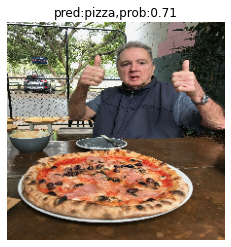

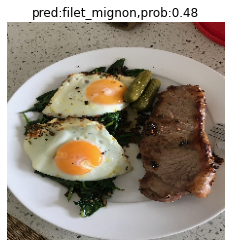

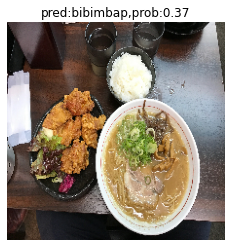

In [47]:
#Make predictions on custom data food images
for img in custom_food_image:
  img=load_and_prep_image(img,scale=False)
  pred_prob=model.predict(tf.expand_dims(img,axis=0))
  pred_class=class_names[pred_prob.argmax()]

  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred:{pred_class},prob:{pred_prob.max():.2f}")
  plt.axis(False)